# Network analysis of corruption risk

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import graph_tool as gt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib as mpl

In [3]:
import graph_tool.topology

In [4]:
import graph_tool.draw

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Times New Roman"})

## Import tables

In [6]:
cnts = pd.read_csv("../../data/pre-process/contratos_4.csv", parse_dates=['start_date'])

cnts['year'] = cnts.start_date.dt.year

cnts = cnts.dropna(subset=['usupplier', 'ubuyer'])

cnts_slevel = cnts[cnts.gvmnt_level=='S']

cnts = cnts[cnts.gvmnt_level=='F']

In [7]:
cnts = cnts[cnts.prop_window >= 0]

In [8]:
cnts['s_interaction'] = 1 - cnts['s_interaction']

## Policy-domains

Let's aggregate on larger policy-domains

In [9]:
big_ramos = {
    'Instituto Mexicano del Seguro Social': 'Health',
    'Energía': 'Energy',
    'Bienestar': 'Social',
    'Salud': 'Health',
    'Comunicaciones y Transportes': 'T and C',
    'Hacienda y Crédito Público': 'Finance',
    'Agricultura y Desarrollo Rural': 'Rural',
    'Instituto de Seguridad y Servicios Sociales de los Trabajadores del Estado': 'Health',
    'Educación Pública': 'Education',
    'Medio Ambiente y Recursos Naturales': 'Environment',
    'Consejo Nacional de Ciencia y Tecnología': 'Science',
    'Cultura': 'Culture',
    'Marina': 'Defense',
    'Defensa Nacional': 'Defense',
    'Economía': 'Economy',
    'Gobernación': 'Home Affairs',
    'Turismo': 'Turism',
    'Entidades no Sectorizadas': 'Other',
    'Función Pública': 'Transparency',
    'Trabajo y Previsión Social': 'Social',
    'Desarrollo Agrario, Territorial y Urbano': 'T and C',
    'Procuraduría General de la República': 'Police',
    'Información Nacional Estadística y Geográfica': 'Demographics',
    'Relaciones Exteriores': 'Foreign Affairs',
    'Oficina de la Presidencia de la República': 'Presidency',
    'Comisión Federal de Competencia Económica': 'Economy',
    'Instituto Federal de Telecomunicaciones': 'T and C',
    'Tribunal Federal de Justicia Administrativa': 'Justice',
    'Tribunales Agrarios': 'Justice',
    'Comisión Reguladora de Energía': 'Energy', 
    'Consejería Jurídica del Ejecutivo Federal': 'Justice',
    'Inteligencia': 'Police',
    'Comisión Nacional de Hidrocarburos': 'Energy',
    'Instituto Nacional de Transparencia, Acceso a la Información y Protección de Datos Personales': 'Home Affairs',
    'Guardia Nacional': 'Police',
    'Seguridad': 'Police'}

In [10]:
df_big_ramos = pd.DataFrame(big_ramos.items(), columns=['desc_ramo', 'policy'])

cnts = pd.merge(cnts, df_big_ramos, how='left')

In [11]:
cnts = cnts.dropna(subset=['policy'])

## Main cores

Is centrality varying much across years?

We consider 5 states:

- Mexico City
- Mexico state
- Jalisco
- Veracruz
- Sonora

## Core vs periphery

Core nodes are in the main core and the rest are in the periphery

In [12]:
agg = cnts.groupby('code_b')[['single_bid', 'prop_window', 's_interaction']].mean().reset_index().rename(
    columns={'code_b': 'state', 'single_bid': 'single bid', 's_interaction': 'supplier dispersion',
             'prop_window': 'proposition window'})

In [13]:
cnts_local = cnts.groupby(['ubuyer', 'usupplier', 'year'])[['single_bid',
                                                    'prop_window',
                                                    's_interaction']].mean().reset_index()
ramos = cnts.groupby(['ubuyer', 'usupplier'])[['policy', 'code_b']].first().reset_index()
weights = cnts.groupby(['ubuyer', 'usupplier']).size().rename('weight').reset_index()
cnts_local = pd.merge(cnts_local, ramos, how='left')
cnts_local = pd.merge(cnts_local, weights, how='left')

In [14]:
def core_periphery_graph(state, year1, year2, per=True):
    
    # categorize variables
    N = cnts_local[cnts_local.year.between(year1, year2)].copy()
    N['single_bid'] = (N['single_bid'] >= cnts[cnts.code_b==state].single_bid.mean())
    N['prop_window'] = (N['prop_window'] <= cnts[cnts.code_b==state].prop_window.mean())
    N['s_interaction'] = (N['s_interaction'] >= cnts[cnts.code_b==state].s_interaction.mean())
    N = N.dropna(subset=['single_bid', 'prop_window', 's_interaction', 'policy'])
    net = N[(N.code_b==state)][['ubuyer',
                       'usupplier',
                       'policy',
                       'single_bid',
                       'prop_window',
                       's_interaction',
                       'weight']].values
    g = gt.Graph(directed=False)

    policy = g.new_edge_property('string')
    single_bid = g.new_edge_property('bool')
    prop_window = g.new_edge_property('bool')
    s_interaction = g.new_edge_property('bool')
    weight = g.new_edge_property('float')
    node_id = g.add_edge_list(net, hashed=True, eprops=[policy,
                                                        single_bid,
                                                        prop_window,
                                                        s_interaction,
                                                        weight])
    kcore = gt.topology.kcore_decomposition(g)
    g.vertex_properties['node_id'] = node_id
    g.edge_properties['policy'] = policy
    g.edge_properties['single_bid'] = single_bid
    g.edge_properties['prop_window'] = prop_window
    g.edge_properties['s_interaction'] = s_interaction
    g.edge_properties['weight'] = weight

    # Core
    core = gt.GraphView(g, vfilt=lambda v: kcore[v] == kcore.a.max())
    # Periphery
    if per:
        per = gt.GraphView(g, vfilt=lambda v: kcore[v] < kcore.a.max())
        per = gt.GraphView(per, vfilt=gt.topology.label_largest_component(per))
    
    return g, core, per

In [15]:
def multi_core_periphery_graph(state, year1, year2, per=True):
    
    # categorize variables
    N = cnts[cnts.year.between(year1, year2)].copy()
    N['single_bid'] = (N['single_bid'] >= cnts[cnts.code_b==state].single_bid.mean())
    N['prop_window'] = (N['prop_window'] <= cnts[cnts.code_b==state].prop_window.mean())
    N['s_interaction'] = (N['s_interaction'] >= cnts[cnts.code_b==state].s_interaction.mean())
    N = N.dropna(subset=['single_bid', 'prop_window', 's_interaction', 'policy'])
    net = N[(N.code_b==state)][['ubuyer',
                       'usupplier',
                       'policy',
                       'single_bid',
                       'prop_window',
                       's_interaction']].values
    g = gt.Graph(directed=False)

    policy = g.new_edge_property('string')
    single_bid = g.new_edge_property('bool')
    prop_window = g.new_edge_property('bool')
    s_interaction = g.new_edge_property('bool')
    node_id = g.add_edge_list(net, hashed=True, eprops=[policy,
                                                        single_bid,
                                                        prop_window,
                                                        s_interaction])
    kcore = gt.topology.kcore_decomposition(g)
    g.vertex_properties['node_id'] = node_id
    g.edge_properties['policy'] = policy
    g.edge_properties['single_bid'] = single_bid
    g.edge_properties['prop_window'] = prop_window
    g.edge_properties['s_interaction'] = s_interaction

    # Core
    core = gt.GraphView(g, vfilt=lambda v: kcore[v] >= np.quantile(kcore.a, .99))
    # Periphery
    if per:
        per = gt.GraphView(g, vfilt=lambda v: kcore[v] < np.quantile(kcore.a, .99))
        per = gt.GraphView(per, vfilt=gt.topology.label_largest_component(per))
    
    return g, core, per

In [16]:
def draw_graph(g, edge_prop='single_bid', **kwargs):
    
    edge_prop = g.ep[edge_prop]
    node_id = g.vp['node_id']
    
    node_color = g.new_vp('string')
    
    for v in g.get_vertices():
        if 's' == node_id[v][0]:
            node_color[v] = 'black'
        else:
            node_color[v] = 'gray'
    
    gt.draw.graph_draw(g,
                       vertex_fill_color=node_color,
                       edge_pen_width=.5,
                       edge_color=edge_prop,
                       ecmap=mpl.cm.bwr,
                       vertex_size=1)

In [17]:
def edge_intersection(g1, g2):
    
    edges1 = list(g1.edges())
    labels1 = g1.vp['node_id']
    edges1 = set([tuple(sorted([labels1[e.source()], labels1[e.target()]])) for e in edges1])
    
    edges2 = list(g2.edges())
    labels2 = g2.vp['node_id']
    edges2 = set([tuple(sorted([labels2[e.source()], labels2[e.target()]])) for e in edges2])
    
    return len(edges1 & edges2) / len(edges1)

In [18]:
def wachs_edge_intersection(g1, g2):
    
    edges1 = list(g1.edges())
    labels1 = g1.vp['node_id']
    edges1 = set([tuple(sorted([labels1[e.source()], labels1[e.target()]])) for e in edges1])
    
    edges2 = list(g2.edges())
    labels2 = g2.vp['node_id']
    edges2 = set([tuple(sorted([labels2[e.source()], labels2[e.target()]])) for e in edges2])
    
    return len(edges1 & edges2) / len(edges1)

## Stability across electoral years

In [19]:
inegi = pd.read_csv('../../data/states/federal.csv')

inegi = inegi[['very_high_r', 'c_very_high_r', 'e_exp_r', 'code']]

inegi = inegi.rename(columns={'code': 'state'})

In [20]:
inegi = inegi.rename(columns={'very_high_r': 'corruption perception'})

In [21]:
sorted(cnts.year.unique())

[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [22]:
electoral_years = {
    "AGU": 2016,
    "BCN": 2013,
    "BCS": 2015,
    "CAM": 2015,
    "CHP": 2018,
    "CHH": 2016,
    "CMX": 2018,
    "COA": 2017,
    "COL": 2016,
    "DUR": 2016,
    "GUA": 2018,
    "GRO": 2015,
    "HID": 2016,
    "JAL": 2018,
    "MEX": 2017,
    "MIC": 2015,
    "MOR": 2018,
    "NAY": 2017,
    "NLE": 2015,
    "OAX": 2016,
    "PUE": 2018,
    "QUE": 2015,
    "ROO": 2016,
    "SLP": 2015,
    "SIN": 2017,
    "SON": 2015,
    "TAB": 2018,
    "TAM": 2016,
    "TLA": 2016,
    "VER": 2018,
    "YUC": 2018,
    "ZAC": 2016}

## Core size and corruption risk

In [23]:
data = []
cols = ['state', 'core ratio']
for state in cnts.code_b.value_counts().index[:]:
    g, core, per = multi_core_periphery_graph(state, 2011, 2019, per=False)
    ratio = core.num_edges() / g.num_edges()
    ratio = float(ratio)
    data.append([state, ratio])
ratio_e = pd.DataFrame(data, columns=cols)

In [24]:
ratio_e = pd.merge(ratio_e, inegi, how='left')

In [25]:
ratio_e = pd.merge(ratio_e, agg, how='left')

In [26]:
ratio_e.corr(method='spearman')

core ratio  corruption perception  c_very_high_r  \
core ratio               1.000000               0.312924       0.296921   
corruption perception    0.312924               1.000000       0.726856   
c_very_high_r            0.296921               0.726856       1.000000   
e_exp_r                  0.127199               0.352521       0.334677   
single bid               0.668988               0.175069       0.105938   
proposition window      -0.489736              -0.146471      -0.329545   
supplier dispersion      0.497801              -0.117874      -0.348240   

                        e_exp_r  single bid  proposition window  \
core ratio             0.127199    0.668988           -0.489736   
corruption perception  0.352521    0.175069           -0.146471   
c_very_high_r          0.334677    0.105938           -0.329545   
e_exp_r                1.000000   -0.011364           -0.346408   
single bid            -0.011364    1.000000           -0.380132   
proposition window    -0.346408   -0.380132            1.000000   
supplier dispersion   -0.086144    0.287390           -0.087977   

                       supplier dispersion  
core ratio                        0.497801  
corruption perception            -0.117874  
c_very_high_r                    -0.348240  
e_exp_r                          -0.086144  
single bid                        0.287390  
proposition window               -0.087977  
supplier dispersion               1.000000

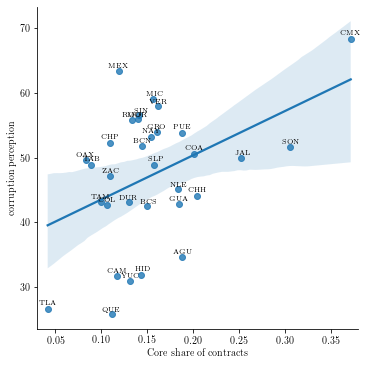

In [27]:
p1 = sns.lmplot(x='core ratio', y='corruption perception', data=ratio_e)
for line in range(0,ratio_e.shape[0]):
     p1.axes[0,0].text(ratio_e['core ratio'][line]+0.01, ratio_e['corruption perception'][line]+0.5, 
     ratio_e['state'][line], horizontalalignment='right', 
     size='x-small', color='black', weight='semibold', alpha=1)
p1.axes[0,0].set_xlim(0.03, .38)
p1.axes[0,0].set_xlabel('Core share of contracts')

p1.savefig('../../figures/core_corruption.pdf')

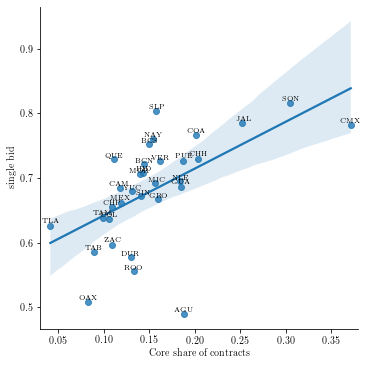

In [28]:
p1 = sns.lmplot(x='core ratio', y='single bid', data=ratio_e)
for line in range(0,ratio_e.shape[0]):
     p1.axes[0,0].text(ratio_e['core ratio'][line]+0.01, ratio_e['single bid'][line]+0.003, 
     ratio_e['state'][line], horizontalalignment='right', 
     size='x-small', color='black', weight='semibold', alpha=1)
p1.axes[0,0].set_xlim(0.03, .38)
p1.axes[0,0].set_xlabel('Core share of contracts')

p1.savefig('../../figures/core_single_bid.pdf')

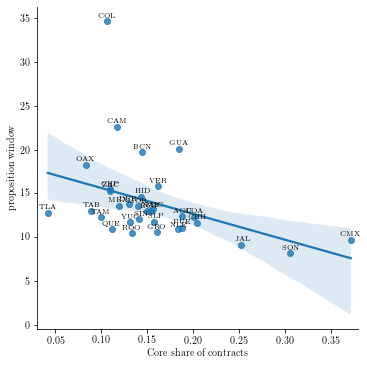

In [29]:
p1 = sns.lmplot(x='core ratio', y='proposition window', data=ratio_e)
for line in range(0,ratio_e.shape[0]):
     p1.axes[0,0].text(ratio_e['core ratio'][line]+0.01, ratio_e['proposition window'][line]+.4, 
     ratio_e['state'][line], horizontalalignment='right', 
     size='x-small', color='black', weight='semibold', alpha=1)
p1.axes[0,0].set_xlim(0.03, .38)
p1.axes[0,0].set_xlabel('Core share of contracts')

p1.savefig('../../figures/core_prop_window.pdf')

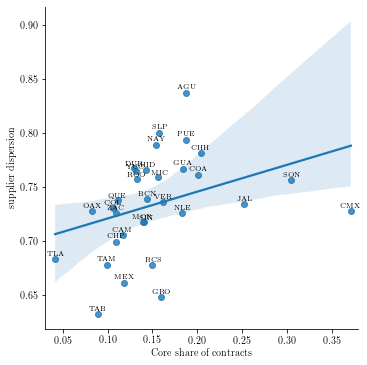

In [30]:
p1 = sns.lmplot(x='core ratio', y='supplier dispersion', data=ratio_e)
for line in range(0,ratio_e.shape[0]):
     p1.axes[0,0].text(ratio_e['core ratio'][line]+0.01, ratio_e['supplier dispersion'][line]+0.003, 
     ratio_e['state'][line], horizontalalignment='right', 
     size='x-small', color='black', weight='semibold', alpha=1)
p1.axes[0,0].set_xlim(0.03, .38)
p1.axes[0,0].set_xlabel('Core share of contracts')

p1.savefig('../../figures/core_s_interaction.pdf')

# Change during government turmoil

In [31]:
data = []
cols = ['state', 'network', 'edge similarity']
for state in cnts.code_b.value_counts().index[:]:
    y = electoral_years[state]

    g, core2, per2 = core_periphery_graph(state, y, y, per=False)
    g, core3, per3 = core_periphery_graph(state, y+1, y+1, per=False)

    j_core = edge_intersection(core2, core3)

    data.append([state, 'core', j_core])

simi = pd.DataFrame(data, columns=cols)

In [32]:
simi = pd.merge(simi, inegi, how='left')

In [33]:
simi = pd.merge(simi, agg, how='left')

In [34]:
simi.groupby('network').corr(method='spearman')

edge similarity  corruption perception  \
network                                                                 
core    edge similarity               1.000000              -0.209002   
        corruption perception        -0.209002               1.000000   
        c_very_high_r                -0.173220               0.726856   
        e_exp_r                      -0.088168               0.352521   
        single bid                    0.120796               0.175069   
        proposition window           -0.074604              -0.146471   
        supplier dispersion          -0.004216              -0.117874   

                               c_very_high_r   e_exp_r  single bid  \
network                                                              
core    edge similarity            -0.173220 -0.088168    0.120796   
        corruption perception       0.726856  0.352521    0.175069   
        c_very_high_r               1.000000  0.334677    0.105938   
        e_exp_r                     0.334677  1.000000   -0.011364   
        single bid                  0.105938 -0.011364    1.000000   
        proposition window         -0.329545 -0.346408   -0.380132   
        supplier dispersion        -0.348240 -0.086144    0.287390   

                               proposition window  supplier dispersion  
network                                                                 
core    edge similarity                 -0.074604            -0.004216  
        corruption perception           -0.146471            -0.117874  
        c_very_high_r                   -0.329545            -0.348240  
        e_exp_r                         -0.346408            -0.086144  
        single bid                      -0.380132             0.287390  
        proposition window               1.000000            -0.087977  
        supplier dispersion             -0.087977             1.000000

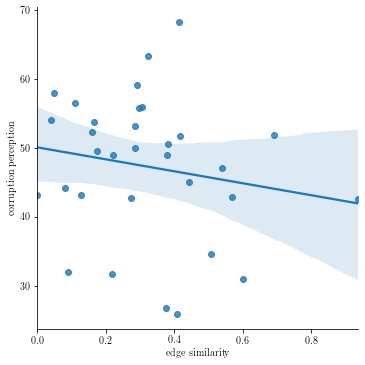

In [35]:
sns.lmplot(x='edge similarity', y='corruption perception', data=simi)

# Public dependencies and corruption risk

In [36]:
cnts['institution'] = cnts.buyer.str.extract(r'(\w+)-.*')

In [37]:
top = cnts.institution.value_counts().index[:10]

In [38]:
cnts_top = cnts[cnts.institution.isin(top)]

In [39]:
cnts_top.institution.value_counts()

IMSS         234316
CFE          172424
DICONSA      107107
ISSSTE        67953
SCT           32303
INDAABIN      24728
CONAGUA       18500
CINVESTAV     16930
SEMAR         16608
PEMEX         16516
Name: institution, dtype: int64

In [40]:
cnts_top.groupby('institution').code_b.nunique()

institution
CFE          32
CINVESTAV     8
CONAGUA      32
DICONSA      16
IMSS         32
INDAABIN      1
ISSSTE       32
PEMEX        12
SCT          32
SEMAR         1
Name: code_b, dtype: int64

In [41]:
risk = cnts_top.groupby('institution')[['single_bid', 'prop_window', 's_interaction']].mean().reset_index()

In [42]:
risk = risk.rename(columns={'single_bid': 'single bid',
                            'prop_window': 'proposition window',
                            's_interaction': 'supplier dispersion'})

In [43]:
risk.columns = risk.columns.str.capitalize()

In [44]:
risk = risk.sort_values(by=['Single bid'])

In [45]:
comp = cnts[cnts.policy.isin(
    cnts_top.policy.unique())].groupby('policy')[['single_bid', 'prop_window', 's_interaction']].mean().reset_index()

policy = cnts_top.groupby('institution').policy.first().reset_index()

policy = pd.merge(policy, comp, how='left')

policy = policy.sort_values(by='institution')

risk = risk.sort_values(by='Institution')

policy['Single bid'] = risk['Single bid'] - policy['single_bid']

policy['Proposition window'] = risk['Proposition window'] - policy['prop_window']

policy['Supplier dispersion'] = risk['Supplier dispersion'] - policy['s_interaction']

In [46]:
policy.columns = policy.columns.str.capitalize()

In [47]:
risk['Single bid'] = risk['Single bid'] - cnts.single_bid.mean()

risk['Proposition window'] = risk['Proposition window'] - cnts.prop_window.mean()

risk['Supplier dispersion'] = risk['Supplier dispersion'] - cnts.s_interaction.mean()

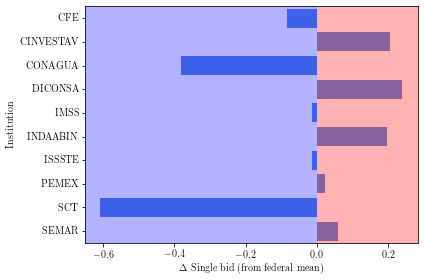

In [48]:
ax_1 = sns.barplot(y='Institution', x='Single bid', data=risk, color='#4287f5')
ax_1.set_xlim(ax_1.get_xlim())
ax_1.axvspan(ax_1.get_xlim()[0], 0, facecolor='b', alpha=0.3)
ax_1.axvspan(0, ax_1.get_xlim()[1] ,facecolor='r', alpha=0.3)
ax_1.set_xlabel(r'$\Delta$ Single bid (from federal mean)')
plt.tight_layout()
plt.savefig('../../figures/inst_single_bid.pdf')

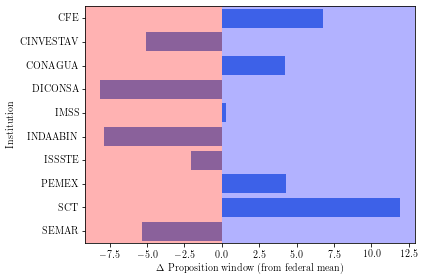

In [49]:
ax_2 = sns.barplot(y='Institution', x='Proposition window', data=risk, color='#4287f5')
ax_2.set_xlim(ax_2.get_xlim())

ax_2.axvspan(ax_2.get_xlim()[0], 0, facecolor='r', alpha=0.3)
ax_2.axvspan(0, ax_2.get_xlim()[1] ,facecolor='b', alpha=0.3)
ax_2.set_xlabel(r'$\Delta$ Proposition window (from federal mean)')
plt.tight_layout()

plt.savefig('../../figures/inst_prop_window.pdf')

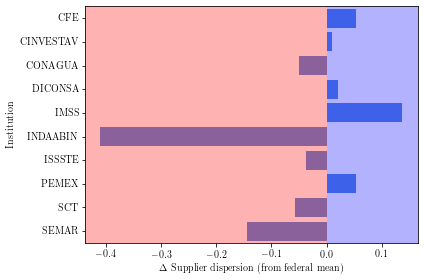

In [50]:
ax_3 = sns.barplot(y='Institution', x='Supplier dispersion', data=risk, color='#4287f5')
ax_3.set_xlim(ax_3.get_xlim())

ax_3.axvspan(ax_3.get_xlim()[0], 0, facecolor='r', alpha=0.3)
ax_3.axvspan(0, ax_3.get_xlim()[1] ,facecolor='b', alpha=0.3)
ax_3.set_xlabel(r'$\Delta$ Supplier dispersion (from federal mean)')
plt.tight_layout()


plt.savefig('../../figures/inst_s_interaction.pdf')

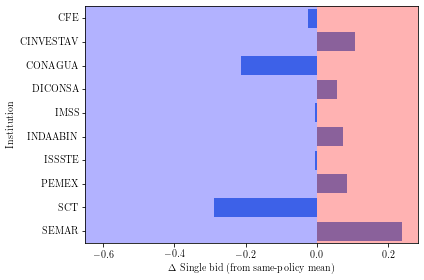

In [51]:
ax = sns.barplot(y='Institution', x='Single bid', data=policy, color='#4287f5')
ax.set_xlim(ax_1.get_xlim())
ax.axvspan(ax.get_xlim()[0], 0, facecolor='b', alpha=0.3)
ax.axvspan(0, ax.get_xlim()[1] ,facecolor='r', alpha=0.3)
ax.set_xlabel(r'$\Delta$ Single bid (from same-policy mean)')
plt.tight_layout()


plt.savefig('../../figures/fair_inst_single_bid.pdf')

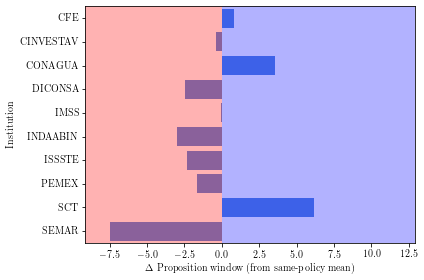

In [52]:
ax = sns.barplot(y='Institution', x='Proposition window', data=policy, color='#4287f5')
ax.set_xlim(ax_2.get_xlim())

ax.axvspan(ax.get_xlim()[0], 0, facecolor='r', alpha=0.3)
ax.axvspan(0, ax.get_xlim()[1] ,facecolor='b', alpha=0.3)
ax.set_xlabel(r'$\Delta$ Proposition window (from same-policy mean)')
plt.tight_layout()

plt.savefig('../../figures/fair_inst_prop_window.pdf')

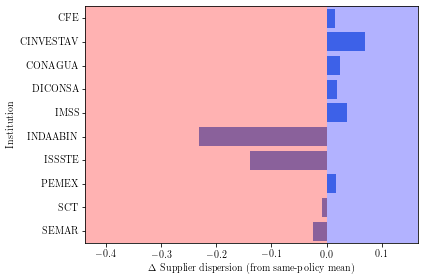

In [53]:
ax = sns.barplot(y='Institution', x='Supplier dispersion', data=policy, color='#4287f5')
ax.set_xlim(ax_3.get_xlim())

ax.axvspan(ax.get_xlim()[0], 0, facecolor='r', alpha=0.3)
ax.axvspan(0, ax.get_xlim()[1] ,facecolor='b', alpha=0.3)

ax.set_xlabel(r'$\Delta$ Supplier dispersion (from same-policy mean)')
plt.tight_layout()

plt.savefig('../../figures/fair_inst_s_interaction.pdf')

In [54]:
cnts[['single_bid', 'prop_window', 's_interaction']].mean()

single_bid        0.738154
prop_window      11.751389
s_interaction     0.729896
dtype: float64

In [55]:
cnts_top.groupby('institution').policy.first()

institution
CFE               Energy
CINVESTAV      Education
CONAGUA      Environment
DICONSA           Social
IMSS              Health
INDAABIN         Finance
ISSSTE            Health
PEMEX             Energy
SCT              T and C
SEMAR            Defense
Name: policy, dtype: object

In [56]:
np.abs(policy['Single bid']).sum() /  np.abs(risk['Single bid']).sum()

0.6016100429073264

In [57]:
np.abs(policy['Proposition window']).sum() /  np.abs(risk['Proposition window']).sum()

0.49791221668646984

In [58]:
np.abs(policy['Supplier dispersion']).sum() /  np.abs(risk['Supplier dispersion']).sum()

0.6032086126752816

In [59]:
policy

Institution       Policy  Single_bid  Prop_window  S_interaction  \
0         CFE       Energy    0.677405    17.707295       0.767068   
1   CINVESTAV    Education    0.835397     7.064569       0.668716   
2     CONAGUA  Environment    0.569502    12.407456       0.655579   
3     DICONSA       Social    0.922762     6.103025       0.730875   
4        IMSS       Health    0.730822    12.061463       0.831064   
5    INDAABIN      Finance    0.862331     6.864666       0.551882   
6      ISSSTE       Health    0.730822    12.061463       0.831064   
7       PEMEX       Energy    0.677405    17.707295       0.767068   
8         SCT      T and C    0.418503    17.515539       0.680379   
9       SEMAR      Defense    0.556196    13.857667       0.610430   

   Single bid  Proposition window  Supplier dispersion  
0   -0.023621            0.785211             0.016113  
1    0.108135           -0.355234             0.070230  
2   -0.213069            3.549644             0.024875  
3    0.055811           -2.468442             0.018969  
4   -0.005097           -0.058900             0.036415  
5    0.073733           -2.963050            -0.231480  
6   -0.005645           -2.338381            -0.138695  
7    0.084947           -1.659700             0.017073  
8   -0.287493            6.146415            -0.007670  
9    0.240348           -7.452536            -0.024838

In [60]:
risk

Institution  Single bid  Proposition window  Supplier dispersion
0         CFE   -0.084370            6.741117             0.053284
1   CINVESTAV    0.205378           -5.042053             0.009050
2     CONAGUA   -0.381721            4.205711            -0.049442
3     DICONSA    0.240419           -8.116806             0.019948
4        IMSS   -0.012429            0.251174             0.137584
5    INDAABIN    0.197911           -7.849773            -0.409494
6      ISSSTE   -0.012976           -2.028307            -0.037527
7       PEMEX    0.024198            4.296206             0.054245
8         SCT   -0.607144           11.910565            -0.057187
9       SEMAR    0.058390           -5.346258            -0.144304

## Institution networks

In [79]:
def inst_multi_core_periphery_graph(inst, year1, year2, per=True):
    
    # categorize variables
    N = cnts[cnts.year.between(year1, year2)].copy()
    N['single_bid'] = (N['single_bid'] >= cnts[cnts.institution==inst].single_bid.mean())
    N['prop_window'] = (N['prop_window'] <= cnts[cnts.institution==inst].prop_window.mean())
    N['s_interaction'] = (N['s_interaction'] >= cnts[cnts.institution==inst].s_interaction.mean())
    N = N.dropna(subset=['single_bid', 'prop_window', 's_interaction', 'policy'])
    net = N[(N.institution==inst)][['ubuyer',
                       'usupplier',
                       'policy',
                       'single_bid',
                       'prop_window',
                       's_interaction']].values
    g = gt.Graph(directed=False)

    policy = g.new_edge_property('string')
    single_bid = g.new_edge_property('bool')
    prop_window = g.new_edge_property('bool')
    s_interaction = g.new_edge_property('bool')
    node_id = g.add_edge_list(net, hashed=True, eprops=[policy,
                                                        single_bid,
                                                        prop_window,
                                                        s_interaction])
    kcore = gt.topology.kcore_decomposition(g)
    g.vertex_properties['node_id'] = node_id
    g.edge_properties['policy'] = policy
    g.edge_properties['single_bid'] = single_bid
    g.edge_properties['prop_window'] = prop_window
    g.edge_properties['s_interaction'] = s_interaction

    # Core
    core = gt.GraphView(g, vfilt=lambda v: kcore[v] >= np.quantile(kcore.a, .99))
    # Periphery
    if per:
        per = gt.GraphView(g, vfilt=lambda v: kcore[v] < np.quantile(kcore.a, .99))
        per = gt.GraphView(per, vfilt=gt.topology.label_largest_component(per))
    
    return g, core, per

In [88]:
data = []
cols = ['institution', 'core ratio']
for inst in cnts_top.institution.unique():
    g, core, per = inst_multi_core_periphery_graph(inst, 2011, 2019, per=False)
    ratio = core.num_edges() / g.num_edges()
    ratio = float(ratio)
    data.append([inst, ratio])
ratio_inst = pd.DataFrame(data, columns=cols)

In [91]:
ratio_inst.columns = ratio_inst.columns.str.capitalize()

In [92]:
policy = pd.merge(policy, ratio_inst, how='left')

In [95]:
policy.corr(method='spearman')

Single_bid  Prop_window  S_interaction  Single bid  \
Single_bid             1.000000    -0.815951       0.092025    0.335372   
Prop_window           -0.815951     1.000000       0.214724   -0.250005   
S_interaction          0.092025     0.214724       1.000000   -0.298786   
Single bid             0.335372    -0.250005      -0.298786    1.000000   
Proposition window    -0.457326     0.445130       0.274395   -0.769697   
Supplier dispersion    0.140247    -0.103660       0.213419    0.030303   
Core ratio             0.829284    -0.768307       0.207321    0.369697   

                     Proposition window  Supplier dispersion  Core ratio  
Single_bid                    -0.457326             0.140247    0.829284  
Prop_window                    0.445130            -0.103660   -0.768307  
S_interaction                  0.274395             0.213419    0.207321  
Single bid                    -0.769697             0.030303    0.369697  
Proposition window             1.000000             0.442424   -0.587879  
Supplier dispersion            0.442424             1.000000   -0.006061  
Core ratio                    -0.587879            -0.006061    1.000000

## Persistence in electoral change

In [100]:
def jaccard_index(x):
    union = len(x[0] | x[1])
    intersection = len(x[0] & x[1])
    
    return intersection / union

In [98]:
def yearly_comparison(df, year_1, year_2, min_cnts=0, r_min_cnts=0, max_cnts=None):
    
    cnts_1 = df[df['year']==year_1]
    cnts_2 = df[df['year']==year_2]

    buyers = set(cnts_1.ubuyer.unique()) & set(cnts_2.ubuyer.unique())

    B1 = cnts_1[cnts_1.ubuyer.isin(buyers)].groupby('ubuyer').usupplier.apply(set).rename("S1").reset_index()
    B1 = B1.drop_duplicates(subset='ubuyer')
    B1['N1'] = B1['S1'].apply(len)
    B2 = cnts_2[cnts_2.ubuyer.isin(buyers)].groupby('ubuyer').usupplier.apply(set).rename("S2").reset_index()
    B2 = B2.drop_duplicates(subset='ubuyer')
    B2['N2'] = B2['S2'].apply(len)
    B = pd.merge(B1, B2, on='ubuyer', how='left')
    if max_cnts:
        B = B[(B.N1 >= min_cnts) & (B.N2 >= min_cnts) & (B.N1 <= max_cnts) & (B.N2 <= max_cnts)]
    else:
        B = B[(B.N1 >= min_cnts) & (B.N2 >= r_min_cnts)]
    B['jaccard'] = B[['S1', 'S2']].apply(jaccard_index, axis=1)

    return B

In [163]:
data = []
columns = ['state', 'persistence_diff', 'persistence_2019']
for state in ratio_e.state.unique():
    B1 = yearly_comparison(cnts[cnts.code_b==state], 2017, 2018)
    B2 = yearly_comparison(cnts[cnts.code_b==state], 2018, 2019)
    diff = B2.jaccard.mean() - B1.jaccard.mean()
    data.append([state, diff, B2.jaccard.mean()])
pers = pd.DataFrame(data, columns=columns)

In [164]:
ratio_e = pd.merge(ratio_e, pers, how='left')

In [168]:
B = yearly_comparison(cnts, 2018, 2019)

In [171]:
B = pd.merge(B, cnts[['ubuyer', 'single_bid', 'prop_window', 's_interaction']], how='left')

In [174]:
B.corr(method='spearman')

N1        N2   jaccard  single_bid  prop_window  \
N1             1.000000  0.900740  0.181915    0.051109     0.008732   
N2             0.900740  1.000000  0.259994    0.076637     0.000596   
jaccard        0.181915  0.259994  1.000000    0.256598    -0.222733   
single_bid     0.051109  0.076637  0.256598    1.000000    -0.576964   
prop_window    0.008732  0.000596 -0.222733   -0.576964     1.000000   
s_interaction  0.138995  0.163402 -0.014982   -0.085429     0.122558   

               s_interaction  
N1                  0.138995  
N2                  0.163402  
jaccard            -0.014982  
single_bid         -0.085429  
prop_window         0.122558  
s_interaction       1.000000

## The case of the cinvestav

In [61]:
cinves = cnts[cnts.institution=='CINVESTAV'][['ubuyer', 'usupplier', 'single_bid', 'prop_window', 's_interaction']]

In [62]:
cinves.mean()

single_bid       0.943532
prop_window      6.709336
s_interaction    0.738946
dtype: float64

In [63]:
cnts['single_bid'].mean()

0.7381537695253351

In [64]:
cnts['prop_window'].mean()

11.75138887298722

In [65]:
cnts['s_interaction'].mean()

0.7298957642640939

In [66]:
edge_list = cinves.groupby(['ubuyer', 'usupplier']).size().rename('weight').reset_index()

In [67]:
stats = cinves.groupby(['ubuyer', 'usupplier'])[['single_bid', 'prop_window', 's_interaction']].mean().reset_index()

In [68]:
edge_list = pd.merge(edge_list, stats, how='left')

In [69]:
edge_list['single_bid'] = edge_list['single_bid'] > cnts['single_bid'].mean()

edge_list['prop_window'] = edge_list['prop_window'] > cnts['prop_window'].mean()

edge_list['s_interaction'] = edge_list['s_interaction'] > cnts['s_interaction'].mean()

In [70]:
g = gt.Graph(directed=False)

In [71]:
weight = g.new_ep('int')
single_bid = g.new_ep('bool')
prop_window = g.new_ep('bool')
s_interaction = g.new_ep('bool')

In [72]:
node_id = g.add_edge_list(edge_list.values, hashed=True, eprops=[weight,
                                                        single_bid,
                                                        prop_window,
                                                        s_interaction])

In [73]:
node_color = g.new_vp('string')

for v in g.get_vertices():
    if 's' == node_id[v][0]:
        node_color[v] = 'black'
    else:
        node_color[v] = 'gray'

In [74]:
pos = gt.draw.sfdp_layout(g)

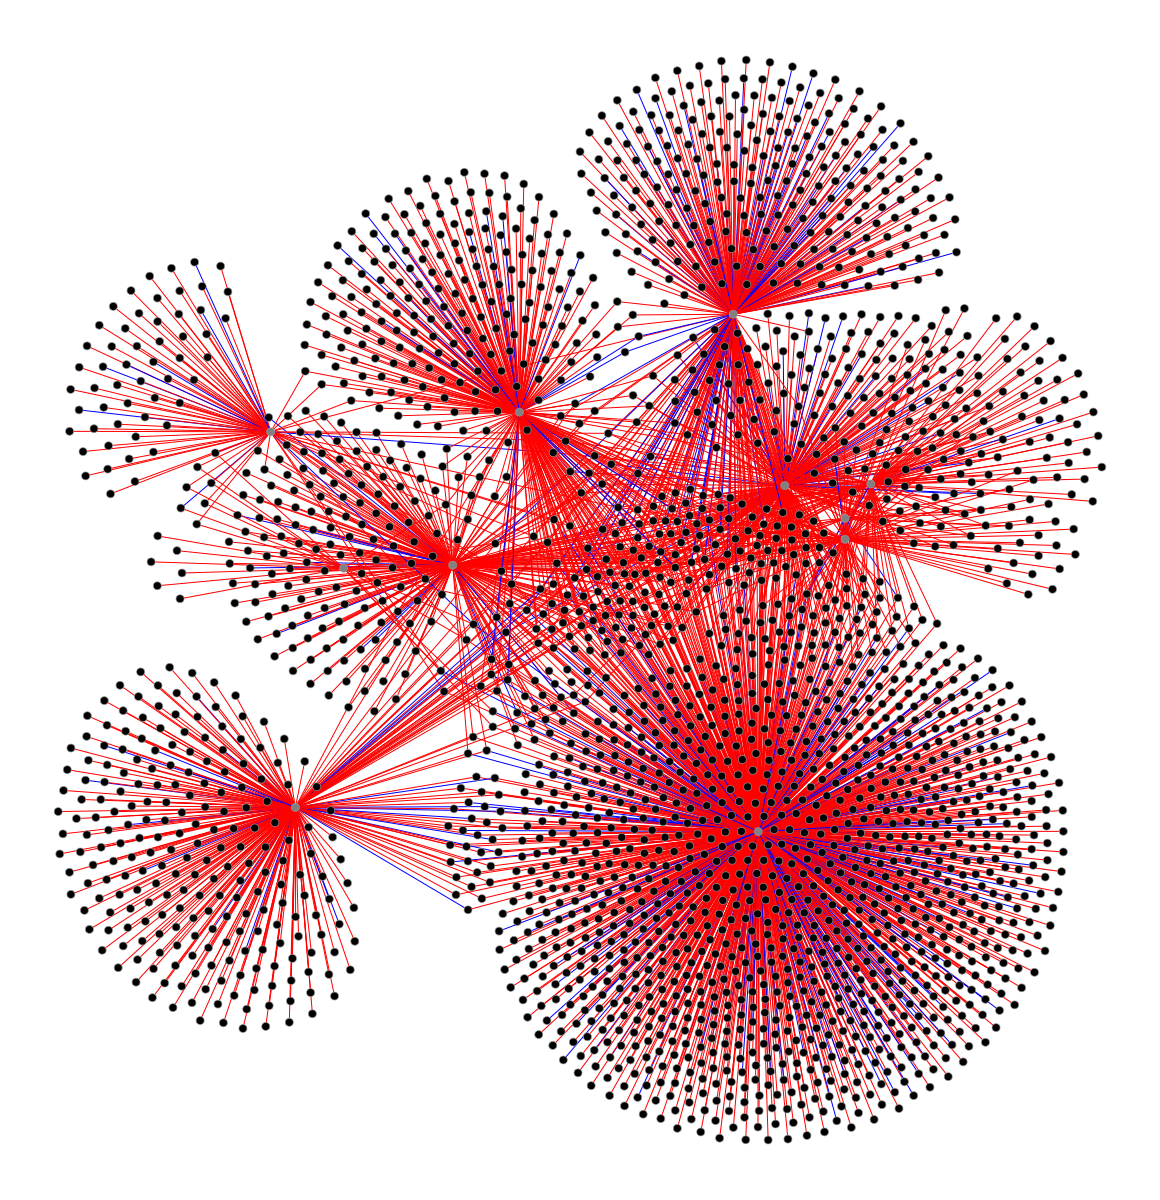

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe3e0453f70, at 0x7fe3d5070a00>

In [75]:
gt.draw.graph_draw(g, pos=pos, vertex_fill_color=node_color,
            vertex_size=4, edge_pen_width=.5,
            edge_color=single_bid, ecmap=plt.cm.bwr)

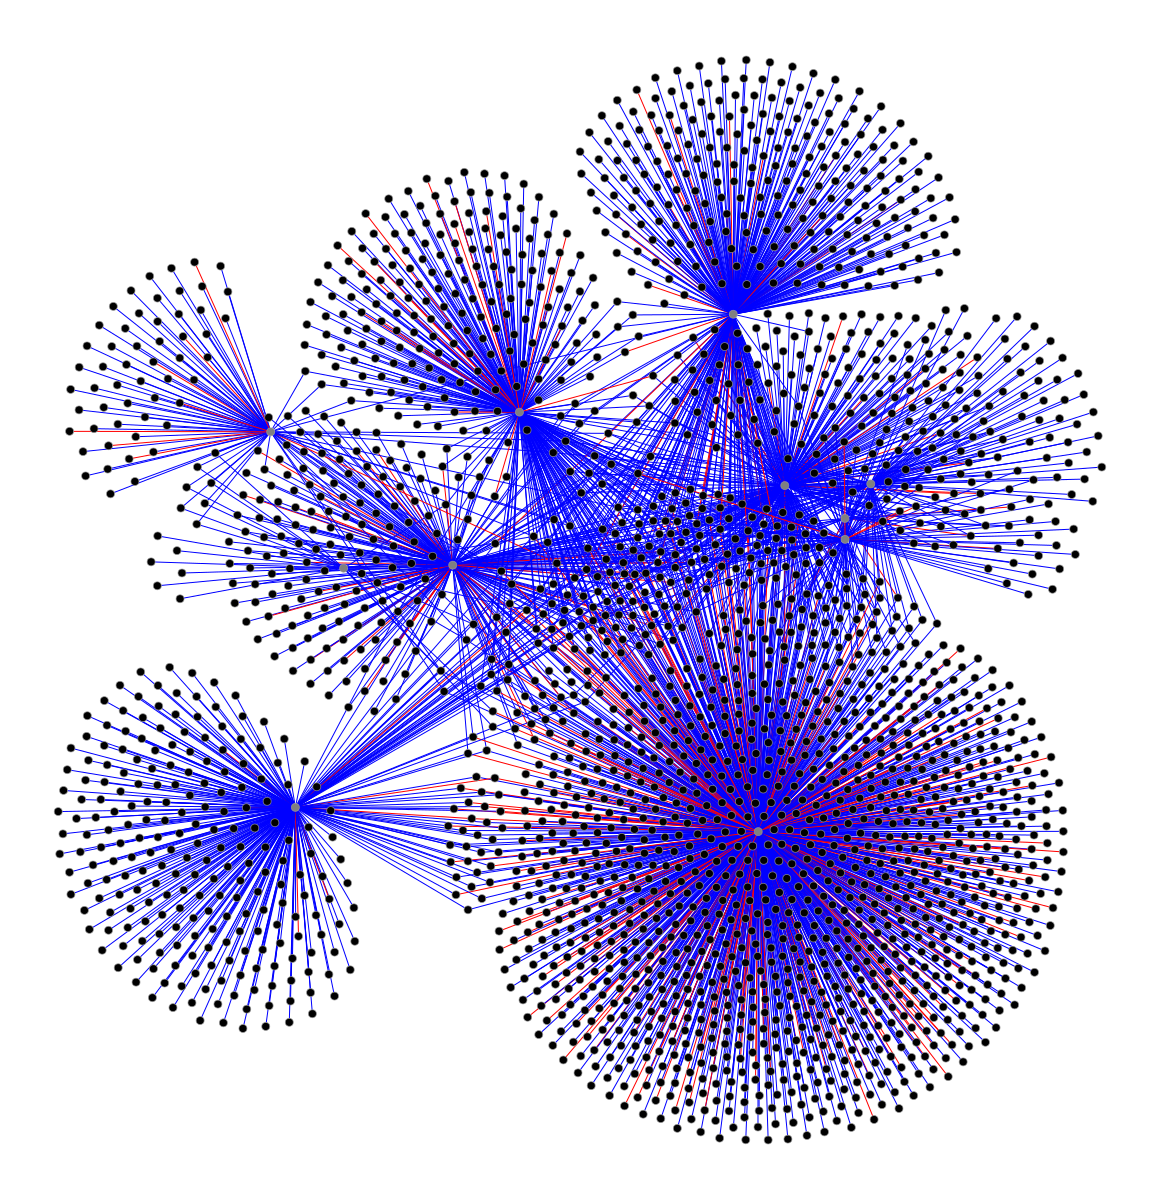

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe3e0453f70, at 0x7fe3d5070a00>

In [76]:
gt.draw.graph_draw(g, pos=pos, vertex_fill_color=node_color,
            vertex_size=4, edge_pen_width=.5,
            edge_color=prop_window, ecmap=plt.cm.bwr)

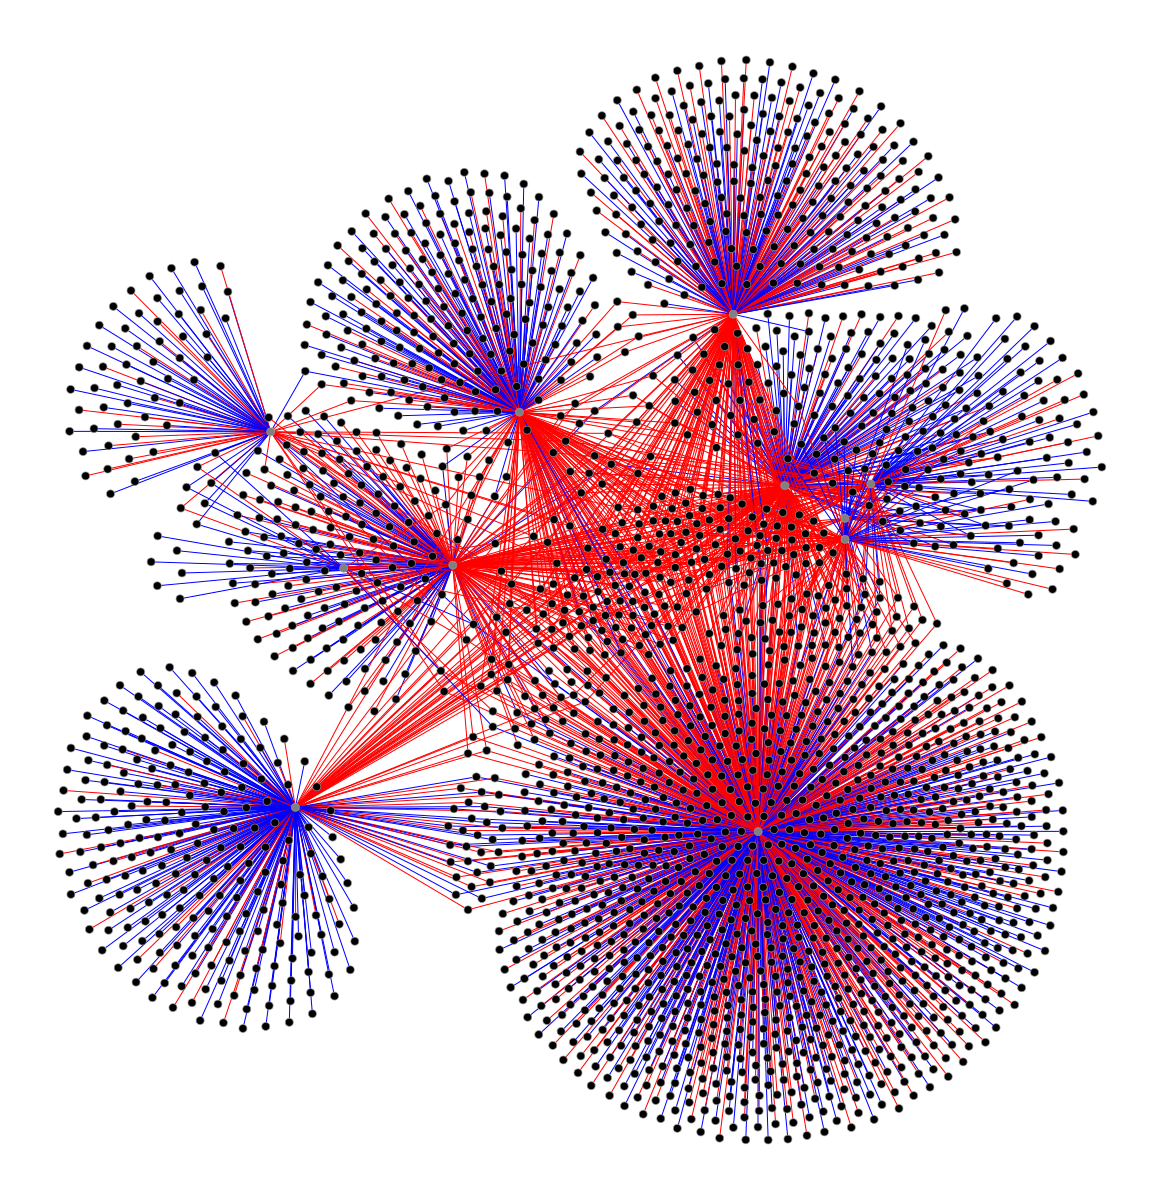

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fe3e0453f70, at 0x7fe3d5070a00>

In [77]:
gt.draw.graph_draw(g, pos=pos, vertex_fill_color=node_color,
            vertex_size=4, edge_pen_width=.5,
            edge_color=s_interaction, ecmap=plt.cm.bwr)